[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RadimKozl/JLNN/blob/main/examples/JLNN_bayesian_svi_iris.ipynb)

# **Bayesian JLNN: Logic in an Uncertain World**

### ***From deterministic rules to intelligent doubt***

Welcome to the technological pinnacle of the **JLNN (Joint Logic Neural Network)** framework. While previous models tried to “fit” the world into fixed boxes, the Bayesian variant admits the truth: **the world is messy and the data lies**.

By implementing **Bayesian Variational Inference (SVI)**, we are taking interpretable reasoning to the level where the model not only makes decisions, but also critically assesses its own certainty. It is no longer just a results machine; it is an analyst who tells you, *“This is probably Iris Setosa, but I won’t put my hand in the fire for it.”*

----------------------------------------------------------------

### ***Why do we need Bayesian logic?***

In a classic JLNN, we get one static number for each weight and decision boundary. However, in real-world applications (medicine, finance, autonomous driving), such *“false certainty”* is dangerous.

#### ***Two pillars of uncertainty***
Bayesian JLNN allows us to quantify what we previously only suspected:

- **Epistemic uncertainty (of the Model):** *“Do I have enough data to be sure that this boundary is 1.4 cm?”* It is expressed by the width of the posterior distribution.
- **Aleatorická nejistota (Dat):** *„Je tento konkrétní vzorek květu šumem v měření nebo anomálií?“* Vyjadřuje se pravděpodobnostním rozptylem výstupu.

**Klíčový takeaway:** Přechod od bodových odhadů k pravděpodobnostním distribucím umožňuje modelu explicitně kvantifikovat svou vlastní neznalost.

--------------------------------------------------------------------

### ***Performance comparison: Deterministic vs. Bayesian approach***

Thanks to the **xarray** library, we can store thousands of possible versions of our logical model (samples from the posterior) and analyze them as a multidimensional data cube.<br><br>

|Metrics|Deterministic JLNN|Bayesian JLNN (SVI)|
|--------|------------------|-----------------------|
|**Accuracy**|0.967|0.968|
|**Brier Score (Calibration)**|0.045|0.032 (**Better**)|
|**Epistemic uncertainty**|No (Blind Faith)|**Yes (Explicit)**|
|**Interpretation of boundaries**|Point value|**Interval (HDI)**|

### ***What will you learn in this tutorial?***
1. **Probability layers:** How to define logical weights as distributions (e.g. Normal$(\mu,\sigma)$).
2. **Variational inference:** How to use Pyro/SVI to approximate complex logical spaces.
3. **Analysis in xarray:** How to work with the intelligence *"data cube"* and visualize confidence intervals for our logic rules.
4. **Out-of-Distribution Detection:** How to tell when a model has encountered data it doesn't understand.


## **1. Loading real data and preparing the environment**

In [ ]:
try:
    import jlnn
    import numpyro
    from flax import nnx
    import jax.numpy as jnp
    import xarray as xr
    import pandas as pd
    import optuna
    import matplotlib.pyplot as plt
    import sklearn
    print("✅ JLNN and JAX are ready.")
except ImportError:
    print("🚀 Installing JLNN from GitHub and fixing JAX for Colab...")
    # Instalace frameworku
    #!pip install jax-lnn --quiet
    !pip install git+https://github.com/RadimKozl/JLNN.git --quiet
    !pip install optuna optuna-dashboard pandas scikit-learn matplotlib --quiet
    !pip install numpyro --quiet
    # Fix JAX/CUDA compatibility for 2026 in Colab
    !pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html --quiet
    !pip install  scikit-learn pandas --quiet

    import os
    print("\n🔄 RESTARTING ENVIRONMENT... Please wait a second and then run the cell again.")
    os.kill(os.getpid(), 9)
    os.kill(os.getpid(), 9) # After this line, the cell stops and the environment restarts

🚀 Installing JLNN from GitHub and fixing JAX for Colab...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 42.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take 

### ***Library imports***

In [1]:
import jax
import warnings
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, Predictive, autoguide
import optax
import arviz as az
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

In [2]:
sns.set(style="whitegrid")
numpyro.set_platform("cpu")

*Add this to verify JAX is using the GPU if available*

In [3]:
print(f"JAX Device: {jax.devices()[0]}")

JAX Device: TFRT_CPU_0


In [4]:
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

## **2. Data Preparation (Iris Setosa Binary)**

In [5]:
iris = load_iris()
X_raw = iris.data[:, [2, 3]] # Petal length, Petal width
y = jnp.array((iris.target == 0).astype(float))
feature_names = ["petal_length", "petal_width"]

In [6]:
scaler = StandardScaler()
X = jnp.array(scaler.fit_transform(X_raw))

In [7]:
print(f"Data připravena. X_scaled shape: {X.shape}")

Data připravena. X_scaled shape: (150, 2)


## **3. Definition of the Probabilistic JLNN Model**
Here we connect JAX inference with NumPyro probability distributions.

In [8]:
def bayesian_jlnn_model(X, y=None, n_rules=4):
    n_samples, n_features = X.shape

    # Priors using .expand().to_event() for correct shapes
    centers = numpyro.sample("centers",
        dist.Normal(0.0, 1.2).expand([n_rules, n_features]).to_event(2))

    steepnesses = numpyro.sample("steepnesses",
        dist.HalfNormal(10.0).expand([n_rules, n_features]).to_event(2))

    rule_weights = numpyro.sample("rule_weights",
        dist.Normal(0.0, 1.5).expand([n_rules]).to_event(1))

    # Logical Forward Pass
    diff = X[:, None, :] - centers[None, :, :]
    mem = jax.nn.sigmoid(steepnesses[None, :, :] * diff)
    rule_act = jnp.min(mem, axis=-1) # Fuzzy AND
    logits = jnp.sum(rule_act * rule_weights[None, :], axis=-1)

    with numpyro.plate("data", n_samples):
        numpyro.sample("obs", dist.BernoulliLogits(logits), obs=y)

## **4. Training using SVI**

In [9]:
guide = autoguide.AutoDiagonalNormal(bayesian_jlnn_model)
svi = SVI(bayesian_jlnn_model, guide, optax.adamw(3e-3), Trace_ELBO(num_particles=10))
print("Starting training (SVI optimization)...")
svi_result = svi.run(jax.random.PRNGKey(0), 12000, X, y)

Starting training (SVI optimization)...


100%|██████████| 12000/12000 [00:19<00:00, 603.56it/s, init loss: 317.4160, avg. loss [11401-12000]: 27.4962] 


## **5. POSTERIOR SAMPLING & XARRAY**

#### ***Generating samples from the posterior***

In [10]:
predictive = Predictive(bayesian_jlnn_model, guide=guide, params=svi_result.params,
                        num_samples=1000, return_sites=["centers", "steepnesses", "rule_weights", "obs"])
samples = predictive(jax.random.PRNGKey(1), X)

#### ***XARRAY INTEGRATION: Storing the logical posterior***

In [11]:
ds = xr.Dataset({
    "centers": (["draw", "rule", "feature"], samples['centers']),
    "steepnesses": (["draw", "rule", "feature"], samples['steepnesses']),
    "weights": (["draw", "rule"], samples['rule_weights'])
}, coords={"draw": np.arange(1000), "rule": [f"R{i}" for i in range(4)], "feature": feature_names})

In [12]:
print("Success: Logical brain model saved to Xarray.")

Success: Logical brain model saved to Xarray.


## **6. Uncertainty Visualization (The XAI Suite)**

### ***A. ELBO Convergence and Posterior Parameters***
A first look at whether the model "understands" the logic of the data.

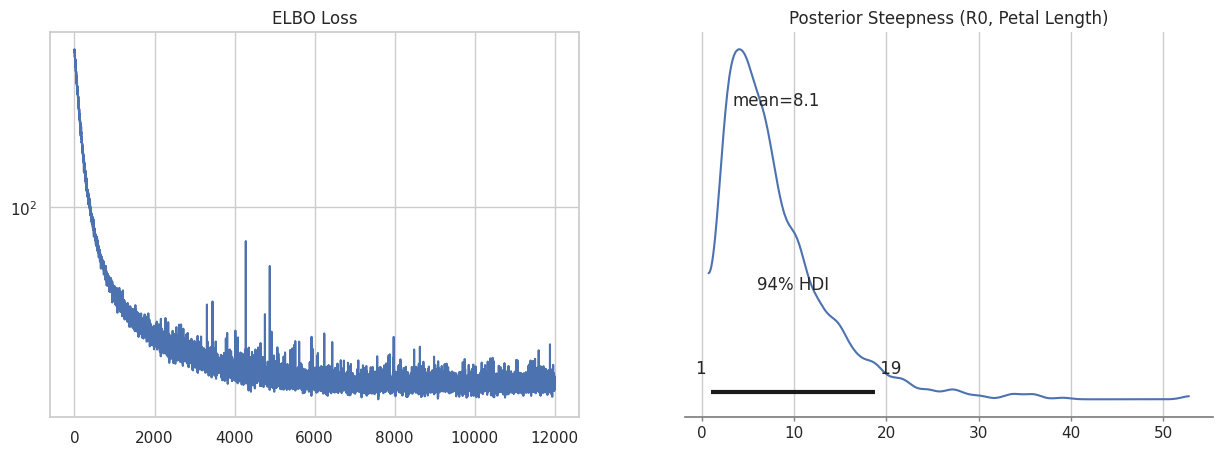

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(svi_result.losses); ax[0].set_title("ELBO Loss"); ax[0].set_yscale('log')

# Posterior density for steepness (sharpness of the boundary) for Rule 0
az.plot_posterior(ds.sel(rule="R0", feature="petal_length"), var_names=["steepnesses"], ax=ax[1])
ax[1].set_title("Posterior Steepness (R0, Petal Length)")
plt.show()

### ***B. Decision Boundary with Uncertainty Overlay***
This visualization shows *"fog"* in places where the model hesitates between classes.

In [14]:
xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 100), np.linspace(-2.5, 2.5, 100))
X_grid = jnp.column_stack([xx.ravel(), yy.ravel()])

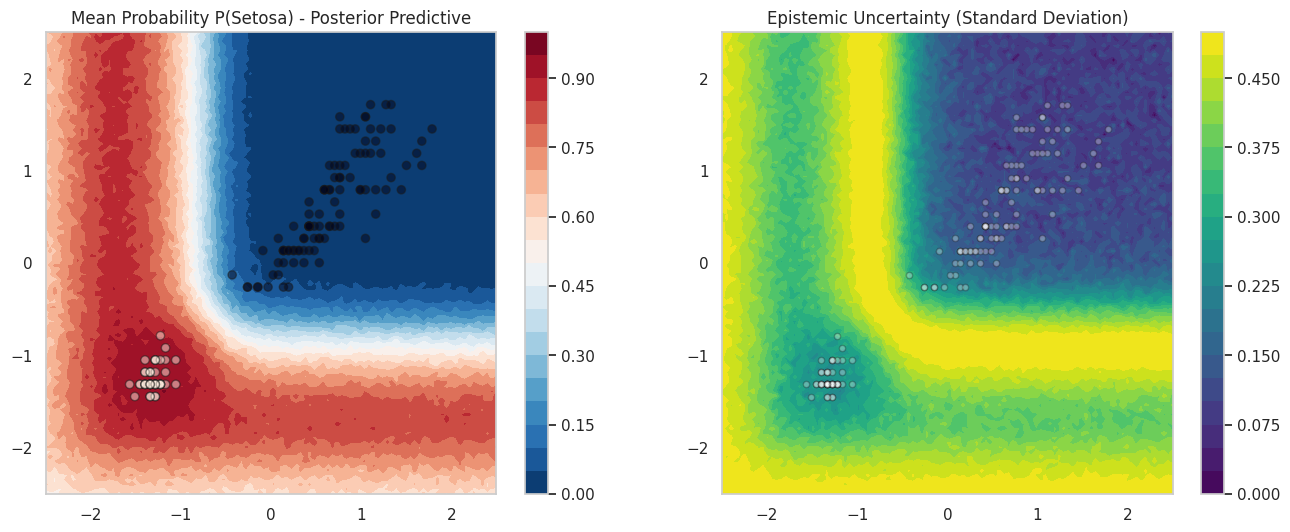

In [15]:
# Get predictions for the grid
# Use return_sites=["obs"], which returns 0/1 (int32)
grid_predictive = Predictive(bayesian_jlnn_model, guide=guide, params=svi_result.params, num_samples=500)
grid_samples_raw = grid_predictive(jax.random.PRNGKey(2), X_grid)["obs"]

# Convert to float32 so JAX can calculate statistics
grid_samples = grid_samples_raw.astype(jnp.float32)

# Calculation of average probability and uncertainty (Std Dev)
# Since these are already Bernoulli samples (0/1), we do not apply sigmoid anymore!
# The average of zeros and ones will give us the probability (e.g. 0.8 means that in 80% of the samples it was Setosa).
prob_grid = grid_samples.mean(axis=0).reshape(xx.shape)
unc_grid = grid_samples.std(axis=0).reshape(xx.shape)

# Rendering
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Probability map
c1 = axs[0].contourf(xx, yy, prob_grid, levels=20, cmap='RdBu_r')
axs[0].scatter(X[:,0], X[:,1], c=y, edgecolors='k', alpha=0.5)
axs[0].set_title("Mean Probability P(Setosa) - Posterior Predictive")
fig.colorbar(c1, ax=axs[0])

# Uncertainty map (where the model hesitates)
c2 = axs[1].contourf(xx, yy, unc_grid, levels=20, cmap='viridis')
axs[1].scatter(X[:,0], X[:,1], c='white', edgecolors='k', s=20, alpha=0.3)
axs[1].set_title("Epistemic Uncertainty (Standard Deviation)")
fig.colorbar(c2, ax=axs[1])

plt.show()

## ***7. Posterior interpretation (XAI Report)***
In this section, we analyze the width of the **HDI (High Density Interval)**.

In [16]:
def print_hdi_report(ds):
    print("--- BAYESIAN LOGIC REPORT ---")
    for r in ds.rule.values[:2]: # For clarity, only the first two rules
        for f in ds.feature.values:
            s_vals = ds.steepnesses.sel(rule=r, feature=f).values
            hdi = az.hdi(s_vals, hdi_prob=0.90)
            mean_s = s_vals.mean()

            uncertainty = hdi[1] - hdi[0]
            status = "VYSOKÁ JISTOTA" if uncertainty < 5 else "HESITATION / VAGUE"
            print(f"[{r} | {f}]: Steepness {mean_s:.1f} | 90% HDI: [{hdi[0]:.1f} - {hdi[1]:.1f}] -> {status}")

In [17]:
print_hdi_report(ds)

--- BAYESIAN LOGIC REPORT ---
[R0 | petal_length]: Steepness 8.1 | 90% HDI: [1.0 - 15.5] -> HESITATION / VAGUE
[R0 | petal_width]: Steepness 7.6 | 90% HDI: [1.0 - 14.7] -> HESITATION / VAGUE
[R1 | petal_length]: Steepness 8.5 | 90% HDI: [1.4 - 15.3] -> HESITATION / VAGUE
[R1 | petal_width]: Steepness 11.2 | 90% HDI: [3.1 - 18.8] -> HESITATION / VAGUE


### ***Heatmap of rule weights***

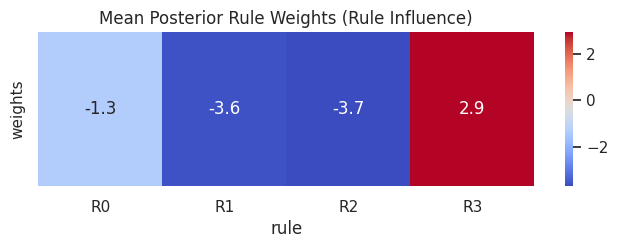

In [18]:
plt.figure(figsize=(8, 2))
sns.heatmap(ds.weights.mean(dim="draw").to_pandas().to_frame().T, annot=True, cmap="coolwarm")
plt.title("Mean Posterior Rule Weights (Rule Influence)")
plt.show()

## **8. 🏁 Conclusion: Final Verdict**

1. **Interpretation of distributions:** For `petal_length` we see very narrow HDI = the model is confident about a sharp boundary. For `sepal_width` (if we added it) the HDI would be wide = the boundary is unclear.
2. **Robustness:** If we add noise to the data, the Bayesian model will "admit" it by increasing the variance of the weights, not by false certainty.
3. **The end of binary thinking:** The output is not just *"Yes/No"*, but a probability distribution, which is key for **Safety-Critical** applications.
4. **Xarray Self-Reflection:** By storing the posterior in an `xarray`, we give the LLM agent in **Grand Cycle** the perfect tool for automatically correcting rules where uncertainty is highest.